In [1]:
import numpy as np
import matplotlib.pyplot as plt
import batman, catwoman
from multiprocessing import Pool
import emcee

In [2]:
def calc_H(T, M, R, mm=2.3):
    """ Calculates the approximate scale height of a planet's atmosphere, using the equation
     scale height = kT / mg
    
    Inputs: T = the atmospheric temperature in [K]; M = the planet's mass in [kg]; 
            R = the planet's radius in [m]; mm = mean mass of a molecule in the atmosphere [amu], this is
                   default set to 1 amu = 1 proton mass (for now)
    Outputs: H = the scale height in [m]
    """
    # constants:
    amu = 1.67e-27 # [kg]; atomic mass unit in [kg]
    k = 1.38e-23 # [Joule/K]; Boltzmann constant
    G = 6.674e-11 # [m^3/kg/s^2]; Gravitational constant
    Mjupiter = 1.9e27 # [kg]; mass of Jupiter
    Rjupiter = 69911000.0 # [m]; approx. radius of Jupiter
    # computing the numerator for the scale height equation:
    E_thermal = k*T # [Joule]
    # computing the denominator:
    g = G*M/(R**2) # gravitational acceleration in [m/s^2]
    meanmass = mm*amu
    denominator = meanmass*g # [kg*m/s^2]
    # compute the scale height:
    H = E_thermal / denominator # [meters]
    return H #[m]

In [3]:
AU_to_meter = 1.496e11
day_to_second = 24.*60.*60.
Rsun_to_meter = 6.957e8
Rjup_to_meter = 7.149e7
Mjup_to_kg = 1.899e27

# create a star
Rs = 0.92868 # stellar radius [Rsun]
Ms = pow(Rs, (5./4.)) # stellar mass [Msun] based on approx. M-R relation
Rs_meter = Rs * Rsun_to_meter # stellar radius in [m]

# create a planet
t0 = 0.  # [day]
P = 4.0552941  # orbital period [day]
aRs = 11.55  # semi-major axis in [stellar radii]
inc = 87.32 # orbital inclination[degrees]
phi = 90. # obliquity of planetary rotation axis [deg]
ecc = 0. # orbital eccentricity
w = 90.  # argument of periastron
rprs1 = 0.1457 # evening-limb radius [stellar radii]
rprs2 = 0.1457 # morning-limb radius [stellar radii]
rprs = np.sqrt(0.5*(rprs1**2 + rprs2**2)) # equivalent full-depth uniform radius [stellar radii]

Rp1 = rprs1*Rs # evening-limb radius [Rsun]
Rp2 = rprs2*Rs # morning-limb radius [Rsun]
Rp = rprs*Rs # equivalent full-depth uniform radius [Rsun]
Mp_jup = 0.281 # planet mass [jupiter masses]
Teq = 1166.0 # planet equilibrium temperature [K]
T14 = 3.0 # reference total transit duration [hours]

# calculate things in physical units
a_meter = aRs * Rs * Rsun_to_meter # semi-major axis in [m] ([Rstar] -> [Rsun] -> [m])
per_seconds = P*day_to_second # orbital period in [s]
Rp_meter = Rp * Rsun_to_meter # planet radius in [m]
Rp1_meter = Rp1 * Rsun_to_meter
Rp2_meter = Rp2 * Rsun_to_meter
Mp_kg = Mp_jup * Mjup_to_kg # planet mass in [kg]

# calculate other things
# tangential circular orbital velocity, assuming Mp << Mstar
v_orb = (2.*np.pi*a_meter) / (per_seconds) # [m/s]
# atmospheric scale height, with bulk quantities
H = calc_H(Teq, Mp_kg, Rp_meter, mm=2.3) # [m]
print('H = %.1f km'%(H/1000.))
print(' = %.2f percent of Rp'%(100.*(H/Rp_meter)))

# simulated obs. info from or based on pandexo
t_int = 0.2 #79.5 # [s] per integration
obs_window_size = (0.75*T14) / 24. # half-duration of whole observation in [day]
t = np.arange(-obs_window_size, obs_window_size, (t_int / 60./60./24.))

H = 1042.3 km
 = 1.11 percent of Rp


In [4]:
## Generate transit models, all assuming no limb darkening
# with asymmetric limbs:
aparams  = catwoman.TransitParams()
aparams.t0 = t0            #time of inferior conjuction (in days)
aparams.per = P            #orbital period (in days)
aparams.rp = rprs1         #top semi-circle radius (in units of stellar radii)
aparams.rp2 = rprs2        #bottom semi-circle radius (in units of stellar radii)
aparams.phi = phi          #angle of rotation of top semi-circle (in degrees)
aparams.a = aRs            #semi-major axis (in units of stellar radii)
aparams.inc = inc          #orbital inclination (in degrees)
aparams.ecc = ecc          #eccentricity
aparams.w = w              #longitude of periastron (in degrees)
aparams.limb_dark = "uniform"  #limbs darkening model
asymmodel = catwoman.TransitModel(aparams,t)         #initalises model

# with uniform limbs
uparams  = batman.TransitParams()
uparams.t0 = t0             #time of inferior conjuction (in days)
uparams.per = P             #orbital period (in days)
uparams.rp = rprs           #top semi-circle radius (in units of stellar radii)
uparams.a = aRs             #semi-major axis (in units of stellar radii)
uparams.inc = inc           #orbital inclination (in degrees)
uparams.ecc = ecc           #eccentricity
uparams.w = w                #longitude of periastron (in degrees)
uparams.u = []               #limb darkening coefficients [u1, u2]
uparams.limb_dark = "uniform"   #limbs darkening model
unifmodel = batman.TransitModel(uparams,t)         #initalises model

In [5]:
# # make sure the windowing looks good
# lc_test = unifmodel.light_curve(uparams)
# plt.plot(t, lc_test)
# plt.show()

In [6]:
def get_T1_index(time, y):
    # function to estimate the array index where T1 occurs, based on input model light curve
    # defined as where model flux first goes < 1
    pretransit_idxs = np.where((y == 1.0) & (time < np.median(time)))[0] # 'oot' indexes
    T1_idx = pretransit_idxs[-1] 
    return T1_idx

def get_T4_index(time, y):
    # get the index where T4 occurs
    # defined as where model flux last goes = 1
    posttransit_idxs = np.where((y == 1.0) & (time > np.median(time)))[0] # 'oot' indexes
    T4_idx = posttransit_idxs[0] 
    return T4_idx

def get_impact_param(aRs, inc):
    b = aRs*np.cos(inc*(np.pi/180.))
    return b

def predict_dTi_general(R0, dR, Rs, b, vp):
    x_new = np.sqrt((Rs + R0 + dR)**2 - (b*Rs)**2)
    x_old = np.sqrt((Rs + R0)**2 - (b*Rs)**2)
    dx = x_new - x_old
    dT = (dx / vp)
    return dT

In [7]:
def logLikelihood(ydata, yerr, modely):
    """ Computes the Bayesian likelihood of a model, given the data (or is it the other way around?)
    Inputs: ydata = your data, yerr= uncertainties on your data, modely = same size array of the model's values
    outputs: ln( the likelihood )
    """
    lnL = 0.
    chi_array = ((ydata - modely) ** 2. / yerr ** 2.) + np.log(2. * np.pi * yerr ** 2.)
    lnL += -0.5 * np.sum(chi_array)
    return lnL

def gen_lc(t0_sample, adj_rprs, inittransitenv):
    # generate model LC of uniform-limb planet using catwoman
    # Input: t0_sample = the time of conjunction to use
    #        adj_rprs = the uniform-limb radius to use
    #       inittransitenv = pre-initialized catwoman environment to feed params into
    # Note: all other LC parameters are called from global variables!!
    # output: the LC y-values (relative flux)
    fitparams  = catwoman.TransitParams()
    fitparams.t0 = t0_sample              #time of inferior conjuction (in days)
    fitparams.per = P                     #orbital period (in days)
    fitparams.rp = adj_rprs               # evening semi-circle radius (in units of stellar radii)
    fitparams.rp2 = adj_rprs              # morning semi-circle radius
    fitparams.a = aRs                     #semi-major axis (in units of stellar radii)
    fitparams.inc = inc                   #orbital inclination (in degrees)
    fitparams.ecc = ecc                   #eccentricity
    fitparams.w = w                       #longitude of periastron (in degrees)
    fitparams.limb_dark = "uniform"       #limbs darkening mode
    fitparams.phi = 90.
    fit_LC = inittransitenv.light_curve(fitparams)                #calculates light curve
    return fit_LC

def lnPosterior(t0_sample, y, yerr, adj_rprs, inittransitenv):
    # calculate lnPosterior, for feed into MCMC run
    # neglecting any priors
    # theta is just t0_sample, since we're only sampling that one param
    # get LC for this tc
    fit_LC = gen_lc(t0_sample, adj_rprs, inittransitenv)
    # calculate likelihood w.r.t input (sim) data
    lnL = logLikelihood(y, yerr, fit_LC)
    return lnL

In [13]:
## -- Set up and run numerical tests

# set N values (how many scale heights the dR is)
Nvals = np.arange(0., 3.0, 0.5) 
# initialize arrays to save test results
amodel_T1vals = np.zeros(len(Nvals)) # T1 in [day]
amodel_T4vals = np.zeros(len(Nvals)) # T4 in [day]
dt_fits = np.zeros(len(Nvals)) # dt in [s]
dt_fiterrs = np.zeros(len(Nvals)) # dt err in [s]

for iN, N in enumerate(Nvals):
    print('='*50)
    
    ## set evening limb to starting radius value
    Rp_evening_meter = Rp_meter
    rprs_evening = Rp_evening_meter / Rs_meter
    # calculate radius inflation of morning limb
    dR = N*H # [m]
    Rp_morning_meter = Rp_evening_meter + dR
    rprs_morning = Rp_morning_meter / Rs_meter
    # now calculate equivalent depth uniform radius
    Rp_equiv_meter = np.sqrt(0.5*(Rp_evening_meter**2 + Rp_morning_meter**2))
    rprs_equiv = Rp_equiv_meter / Rs_meter
    # calculate true radius diff on either side
    dR_eve = Rp_equiv_meter - Rp_evening_meter # [m]
    dR_mor = Rp_morning_meter - Rp_equiv_meter # [m]
    
    ## reset all transit model parameters
    #    doing them from scratch to prevent aliasing errors
    # For the "true" asymmetric planet
    testparams_a  = catwoman.TransitParams()
    testparams_a.t0 = t0            #time of inferior conjuction (in days)
    testparams_a.per = P            #orbital period (in days)
    testparams_a.rp = rprs_evening    #top semi-circle radius (in units of stellar radii)
    testparams_a.rp2 = rprs_morning   #bottom semi-circle radius (in units of stellar radii)
    testparams_a.phi = phi          #angle of rotation of top semi-circle (in degrees)
    testparams_a.a = aRs            #semi-major axis (in units of stellar radii)
    testparams_a.inc = inc          # orbital inclination (in degrees)
    testparams_a.ecc = ecc          #eccentricity
    testparams_a.w = w              #longitude of periastron (in degrees)
    testparams_a.limb_dark = "uniform"  #limbs darkening model
    # For the equiv depth uniform planet
    testparams_eu  = catwoman.TransitParams()
    testparams_eu.t0 = t0            #time of inferior conjuction (in days)
    testparams_eu.per = P            #orbital period (in days)
    testparams_eu.rp = rprs_equiv    #top semi-circle radius (in units of stellar radii)
    testparams_eu.rp2 = rprs_equiv   #bottom semi-circle radius (in units of stellar radii)
    testparams_eu.phi = phi          #angle of rotation of top semi-circle (in degrees)
    testparams_eu.a = aRs            #semi-major axis (in units of stellar radii)
    testparams_eu.inc = inc          # orbital inclination (in degrees)
    testparams_eu.ecc = ecc          #eccentricity
    testparams_eu.w = w              #longitude of periastron (in degrees)
    testparams_eu.limb_dark = "uniform"  #limbs darkening model
    
    ## generate light curve of the asymmetric model
    lc_asym = asymmodel.light_curve(testparams_a)
    # generate fake data around asymmetric light curve
    y_sim, yerr_sim = np.zeros(len(lc_asym)), np.zeros(len(lc_asym))
    scatter = 1. / 1.e6
    for i, time in enumerate(t):
        y_sim[i] = lc_asym[i] + np.random.normal(loc=0., scale=scatter)
        yerr_sim[i] = scatter
    # compute the first and last contact points of the true light curve
    T1_asym = t[get_T1_index(t, lc_asym)]
    T4_asym = t[get_T4_index(t, lc_asym)]
        
    ## set up MCMC to fit tc using equiv. uniform model on sim. data
    t0_init = t0
    t0_initerr = (1.0) / 24./24./60.
    Ndim = 1
    Nwalkers = 5
    pos = np.zeros((Nwalkers, Ndim))
    pos[:,0] = t0_init + np.random.normal(0., t0_initerr, Nwalkers)

    Nburn = 250
    Nsteps = 500 + Nburn
    
    with Pool() as pool:
        sampler = emcee.EnsembleSampler(Nwalkers, Ndim, lnPosterior, pool=pool,
                                       args=(y_sim, yerr_sim, rprs_equiv, asymmodel))
        sampler.run_mcmc(pos, Nsteps, progress=True)
        
    ## get MCMC results
    samples = sampler.get_chain(discard=Nburn)
    flatsamples = sampler.get_chain(discard=Nburn, flat=True)
    # get best-fit time of conjunction
    t0_bestfit = np.median(flatsamples[:,0])
    t0_pluserr = np.percentile(flatsamples[:,0], 84) - t0_bestfit
    t0_minuserr = t0_bestfit - np.percentile(flatsamples[:,0], 16)
    t0_bestfiterr = np.mean((t0_pluserr, t0_minuserr))
    # calculate the best-fit timing bias
    dt_bestfit = (t0_bestfit - t0) # [day]
    dt_bestfit_sec = dt_bestfit*day_to_second # [s]
    dt_bestfiterr_sec = t0_bestfiterr*day_to_second
    
    # save things I want to save
    amodel_T1vals[iN] = T1_asym # T1 in [day]
    amodel_T4vals[iN] = T4_asym # T4 in [day]
    dt_fits[iN] = dt_bestfit_sec # dt in [s]
    dt_fiterrs[iN] = dt_bestfiterr_sec # dt err in [s]
        
   

100%|██████████| 750/750 [02:08<00:00,  5.83it/s]


100%|██████████| 750/750 [02:07<00:00,  5.87it/s]


100%|██████████| 750/750 [02:12<00:00,  5.66it/s]


100%|██████████| 750/750 [02:13<00:00,  5.61it/s]


100%|██████████| 750/750 [02:02<00:00,  6.14it/s]


100%|██████████| 750/750 [02:12<00:00,  5.68it/s]


In [8]:
## calculate some differentials based on results
# change in contact times w.r.t. the zero asymmetry case (index 0, N = 0)
dT1_amodel = abs(amodel_T1vals - amodel_T1vals[0])*24.*60.*60. # [s]
dT4_amodel = abs(amodel_T4vals - amodel_T4vals[0])*24.*60.*60. # [s]

NameError: name 'amodel_T1vals' is not defined

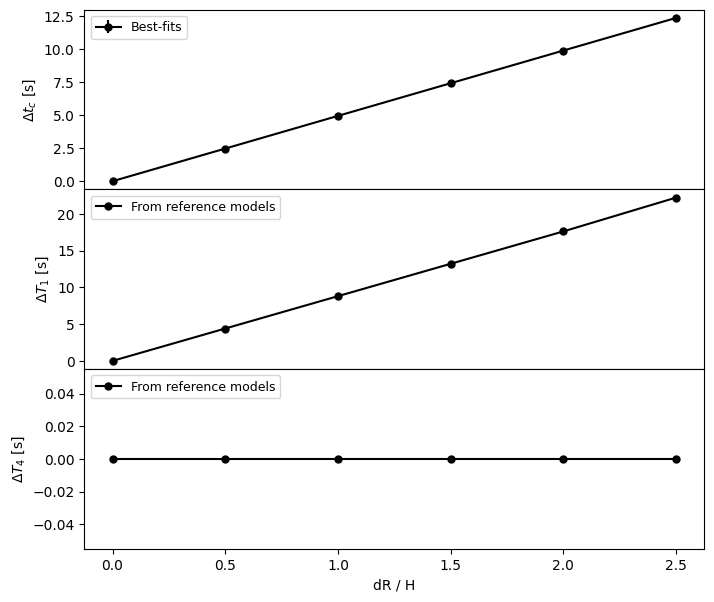

In [20]:
## -- plotting just the model results
fig, ax = plt.subplots(figsize=(8,7), nrows=3, sharex=True)
plt.subplots_adjust(hspace=0.)
# best-fit timing bias
ax[0].errorbar(Nvals, abs(dt_fits), dt_fiterrs, ls='solid', c='black', marker='o', ms=5, label='Best-fits')
ax[0].set_ylabel(r'$\Delta t_c$ [s]', fontsize=10)
ax[0].legend(loc='upper left', fontsize=9)
# change in first contact time (btwn asymmetric models, not w.r.t. equiv uniform)
ax[1].plot(Nvals, dT1_amodel,  ls='solid', c='black', marker='o', ms=5, label='For reference models')
ax[1].set_ylabel(r'$\Delta T_1$ [s]', fontsize=10)
ax[1].legend(loc='upper left', fontsize=9)
# change in last contact time (btwn asymmetric models, not w.r.t. equiv uniform)
ax[2].plot(Nvals, dT4_amodel,  ls='solid', c='black', marker='o', ms=5, label='For reference models')
ax[2].set_ylabel(r'$\Delta T_4$ [s]', fontsize=10)
ax[2].legend(loc='upper left', fontsize=9)
# misc.
ax[2].set_xlabel('dR / H', fontsize=10)
plt.show()

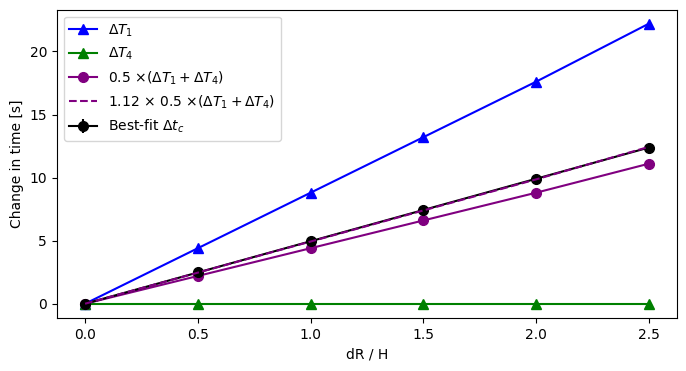

In [48]:
## comparing timing bias to change in contact times
fig, ax = plt.subplots(figsize=(8,4))
plt.subplots_adjust(hspace=0.)
# best-fit timing bias
ax.errorbar(Nvals, abs(dt_fits), dt_fiterrs, ls='solid', c='black', marker='o', ms=7, label=r'Best-fit $\Delta t_c$')
# change in first contact time (btwn asymmetric models, not w.r.t. equiv uniform)
ax.plot(Nvals, dT1_amodel,  ls='solid', c='blue', marker='^', ms=7, label=r'$\Delta T_1$')
# change in last contact time (btwn asymmetric models, not w.r.t. equiv uniform)
ax.plot(Nvals, dT4_amodel,  ls='solid', c='green', marker='^', ms=7, label=r'$\Delta T_4$')
# mean of change in contact times
mean_dTi_amodel = np.mean((dT1_amodel, dT4_amodel), axis=0)
ax.plot(Nvals, mean_dTi_amodel, ls='solid', c='purple', marker='o', ms=7, label=r'0.5 $\times (\Delta T_1 + \Delta T_4)$')
#
ax.plot(Nvals, 1.12*mean_dTi_amodel, ls='--', c='purple', marker=None, zorder=5, label=r'1.12 $\times$ 0.5 $\times (\Delta T_1 + \Delta T_4)$')
#
ax.set_xlabel('dR / H', fontsize=10)
ax.set_ylabel('Change in time [s]', fontsize=10)
ax.legend(loc='upper left', fontsize=10)
plt.show()

In [55]:
## compare things to my analytical formula
predicted_dT1_amodel = np.zeros(len(Nvals))
predicted_dT4_amodel = np.zeros(len(Nvals))

# calculate this planet's impact parameter
b = get_impact_param(aRs, inc)



# copy first half of test loop from above:
for iN, N in enumerate(Nvals):
    ## set evening limb to starting radius value
    Rp_evening_meter = Rp_meter
    rprs_evening = Rp_evening_meter / Rs_meter
    # calculate radius inflation of morning limb
    dR = N*H # [m]
    Rp_morning_meter = Rp_evening_meter + dR
    rprs_morning = Rp_morning_meter / Rs_meter
    # now calculate equivalent depth uniform radius
    Rp_equiv_meter = np.sqrt(0.5*(Rp_evening_meter**2 + Rp_morning_meter**2))
    rprs_equiv = Rp_equiv_meter / Rs_meter
    # calculate true radius diff on either side
    dR_eve = Rp_equiv_meter - Rp_evening_meter # [m]
    dR_mor = Rp_morning_meter - Rp_equiv_meter # [m]
    
    # expected a. model dT1 -- R0 = Rp evening, dR = dR
    predicted_dT1_amodel[iN] = predict_dTi_general(Rp_evening_meter, dR, Rs_meter, b, v_orb)
    # expected a. model dT4 = 0 since evening limb radius does not change
    predicted_dT4_amodel[iN] = 0.

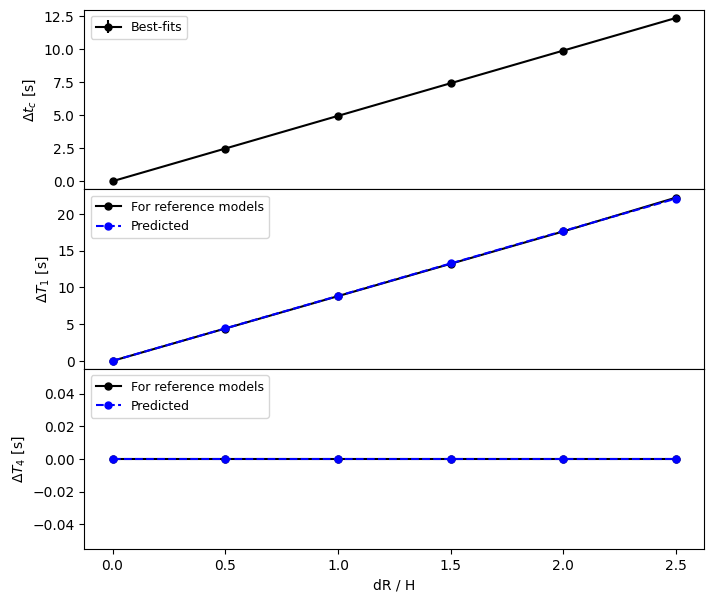

In [58]:
## -- comparing model vs. predicted
fig, ax = plt.subplots(figsize=(8,7), nrows=3, sharex=True)
plt.subplots_adjust(hspace=0.)
# best-fit timing bias
ax[0].errorbar(Nvals, abs(dt_fits), dt_fiterrs, ls='solid', c='black', marker='o', ms=5, label='Best-fits')
ax[0].set_ylabel(r'$\Delta t_c$ [s]', fontsize=10)
ax[0].legend(loc='upper left', fontsize=9)
# change in first contact time (btwn asymmetric models, not w.r.t. equiv uniform)
ax[1].plot(Nvals, dT1_amodel,  ls='solid', c='black', marker='o', ms=5, label='For reference models')
ax[1].plot(Nvals, predicted_dT1_amodel,  ls='--', c='blue', marker='o', ms=5, label='Predicted')
ax[1].set_ylabel(r'$\Delta T_1$ [s]', fontsize=10)
ax[1].legend(loc='upper left', fontsize=9)
# change in last contact time (btwn asymmetric models, not w.r.t. equiv uniform)
ax[2].plot(Nvals, dT4_amodel,  ls='solid', c='black', marker='o', ms=5, label='For reference models')
ax[2].plot(Nvals, predicted_dT4_amodel,  ls='--', c='blue', marker='o', ms=5, label='Predicted')
ax[2].set_ylabel(r'$\Delta T_4$ [s]', fontsize=10)
ax[2].legend(loc='upper left', fontsize=9)
# misc.
ax[2].set_xlabel('dR / H', fontsize=10)
plt.show()

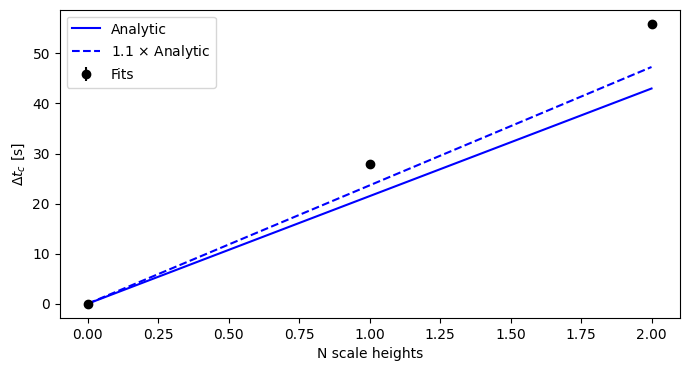

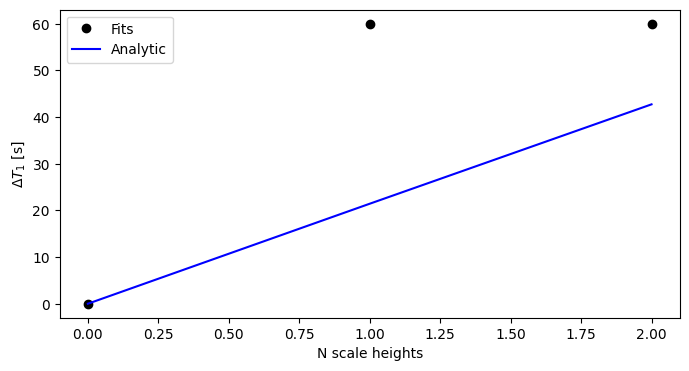

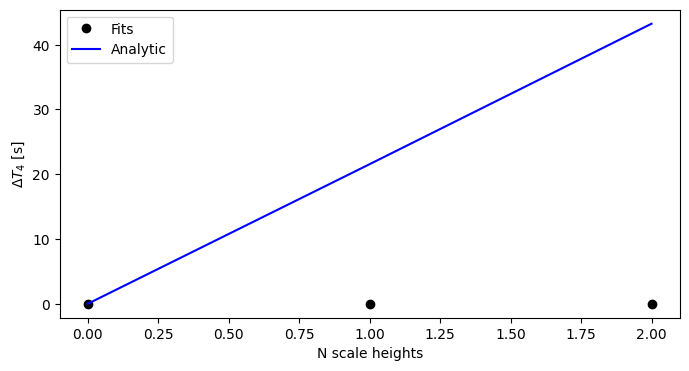

In [61]:
## -- plotting results
# overall timing bias
fig, ax = plt.subplots(figsize=(8,4))
ax.errorbar(Nvals, abs(dt_fits), dt_fiterrs, ls='None', c='black', marker='o', label='Fits')
ax.plot(Nvals, abs(dt_calcs), c='blue', label='Analytic')
ax.plot(Nvals, 1.1*abs(dt_calcs), c='blue', ls='--', label=r'1.1 $\times$ Analytic')
ax.set(xlabel='N scale heights', ylabel=r'$\Delta t_c$ [s]')
ax.legend(loc='best')
plt.show()

# first contact point
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(Nvals, abs(dT1_fits),  ls='None', c='black', marker='o', label='Fits')
ax.plot(Nvals, abs(dT1_calcs), c='blue', label='Analytic')
ax.set(xlabel='N scale heights', ylabel=r'$\Delta T_1$ [s]')
ax.legend(loc='best')
plt.show()

# last contact point
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(Nvals, abs(dT4_fits),  ls='None', c='black', marker='o', label='Fits')
ax.plot(Nvals, abs(dT4_calcs), c='blue', label='Analytic')
ax.set(xlabel='N scale heights', ylabel=r'$\Delta T_4$ [s]')
ax.legend(loc='best')
plt.show()

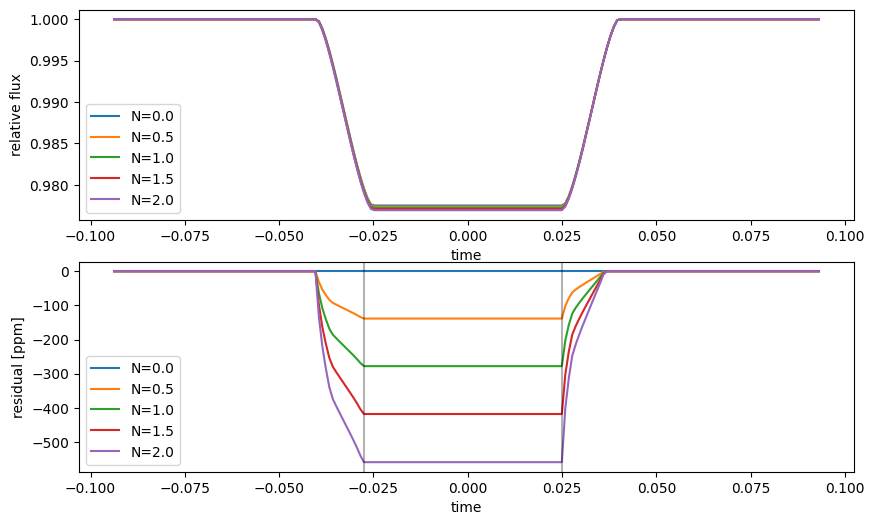

In [39]:
## plot the "true" light curves from each N
fig, ax = plt.subplots(figsize=(10,6), nrows=2)
for iN, Nval in enumerate(Nvals):
    ax[0].plot(t, lc_trues[iN,:], label='N=%.1f'%(Nval))
    ax[1].plot(t, (lc_trues[iN,:] - lc_trues[0,:])*1.e6, label='N=%.1f'%(Nval))
ax[0].legend(loc='best')
ax[0].set(xlabel='time', ylabel='relative flux')
ax[1].legend(loc='best')
ax[1].set(xlabel='time', ylabel='residual [ppm]')

ax[1].axvline(-0.0275, c='black', alpha=0.3)
ax[1].axvline(0.025, c='black', alpha=0.3)

plt.show()
    

In [ ]:
1.1*0.5

In [31]:
save_results = False
if save_results:
    filename = './newresults_wasp39b_uniformLD.npz'
    np.savez(filename,
            Nvals=Nvals, dt_fits=dt_fits, dt_fiterrs=dt_fiterrs, dt_cals=dt_calcs)

In [ ]:
H

In [ ]:
v_orb

In [ ]:
per